# <u>Predicting Loan Approval</u>

**Group 12: Carissa Ying Geok Teng (A0205190R), Chanell Ng (A0203547J), Kuek Yan Ling (A0205292L)**

## Table of Content

- [Importing Packages](#importing_packages)
- [Cleaning Data](#cleaning_data)
- [Logistic Regression](#lr)
    - [Result](#lr_result)
    - [Evaluation](#lr_evaluation)
- [Decision Tree](#dt)
    - [Result](#dt_result)
    - [Evaluation](#dt_evaluation)
- [K Nearest Neighbours](#knn)
    - [Result](#knn_result)
    - [Evaluation](#knn_evaluation)
- [Random Forest](#rf)
    - [Result](#rf_result)
    - [Evaluation](#rf_evaluation)
- [Gradient Boosting](#gb)
    - [Result](#gb_result)
    - [Evaluation](#gb_evaluation)
- [Comparing Models](#comparing_models)
- [Final Model: Logistic Regression](#final_model)
    - [Test Result](#test_result)
    - [Benefit Analysis](#benefit)

## Importing Packages <a name="importing_packages"></a>

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For Encoding
from sklearn.preprocessing import OneHotEncoder

# For scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Models 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Model Building
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

# Import xgboost as xgb
from copy import deepcopy
import time

# Evaluating model performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# For visualisation
from sklearn.metrics import plot_roc_curve
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

SEED = 1

## Cleaning Data <a name="cleaning_data"></a>

In [2]:
fileName = './Loan_Train.csv'

# Drop na
df = pd.read_csv(fileName)
df.dropna(inplace=True)

# Cleaning y data
df.replace({"Loan_Status":{'N':0,'Y':1}},inplace=True)

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1


### Encoding

In [3]:
continuous_variables = ['LoanAmount','ApplicantIncome','CoapplicantIncome']
ordinal_variables = ['Dependents', 'Loan_Amount_Term']
categorical_variables = {'Property_Area': ["Rural", "Semiurban", "Urban"]}
binary_variables = {'Gender':'Male', 'Married':'Yes', 'Education':'Graduate', 'Self_Employed':'Yes', 'Credit_History':1.0}
ordinal_to_int = {'Dependents': {"0":0, "1":1, "2":2, "3+":3}, 
                  'Loan_Amount_Term': {36:0, 60:1, 84:2, 120:3, 180:4, 240:5, 300:6, 360:7, 480:8}}

In [4]:
#preprocessing function removes columns: Loan_ID (unique for every loan) and Loan_Status (target variable)

def preprocessing(df, continuous_variables, ordinal_variables, categorical_variables, binary_variables, ordinal_mapping, ordinal=True):

    new = df[continuous_variables]
    
    pd.options.mode.chained_assignment = None
    if ordinal:
        # Ordinal encode
        for var in ordinal_variables:
            new[var] = df[var].replace(ordinal_to_int[var])
    else:
        # Dummy encode for logistic regression
        for var in ordinal_variables:
            for val in ordinal_to_int[var]:
                new[var + '_' + str(val)] = np.where(df[var]==val, 1, 0)

    # Dummy encode for categorical
    for var in categorical_variables:
        for val in categorical_variables[var]:
            new[var + '_' + str(val)] = np.where(df[var]==val, 1, 0)

    for var in binary_variables:
        # get first val in df
        val = binary_variables[var]
        new[var + '_' + str(val)] = np.where(df[var]==val, 1, 0)

    return new

Example of use of preprocessing function:

In [5]:
eg = preprocessing(df, continuous_variables, ordinal_variables, categorical_variables, binary_variables, ordinal_to_int, False)
eg.head()

,LoanAmount,ApplicantIncome,CoapplicantIncome,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Loan_Amount_Term_36,Loan_Amount_Term_60,Loan_Amount_Term_84,...,Loan_Amount_Term_360,Loan_Amount_Term_480,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Gender_Male,Married_Yes,Education_Graduate,Self_Employed_Yes,Credit_History_1.0
1,128.0,4583,1508.0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,1,1,0,1
2,66.0,3000,0.0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
3,120.0,2583,2358.0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,1,0,0,1
4,141.0,6000,0.0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,1,0,1
5,267.0,5417,4196.0,0,0,1,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1


### Splitting train and test data

In [6]:
# Splitting into independent and dependent
X = df.drop(columns = ['Loan_Status','Loan_ID'])
y = df.Loan_Status

#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

#Splitting the data into validation and train sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=SEED)

#Process data for different models
X_train_tree = preprocessing(X_train, continuous_variables, ordinal_variables, categorical_variables, 
                             binary_variables, ordinal_to_int, True)
X_val_tree = preprocessing(X_val, continuous_variables, ordinal_variables, categorical_variables, 
                             binary_variables, ordinal_to_int, True)
X_test_tree = preprocessing(X_test, continuous_variables, ordinal_variables, categorical_variables, 
                             binary_variables, ordinal_to_int, True)

X_train_reg = preprocessing(X_train, continuous_variables, ordinal_variables, categorical_variables, 
                             binary_variables, ordinal_to_int, False)
X_val_reg = preprocessing(X_val, continuous_variables, ordinal_variables, categorical_variables, 
                             binary_variables, ordinal_to_int, False)
X_test_reg = preprocessing(X_test, continuous_variables, ordinal_variables, categorical_variables, 
                             binary_variables, ordinal_to_int, False)

### Observation about the Data Distributiuon:
There are more loan approvals than disapprovals.

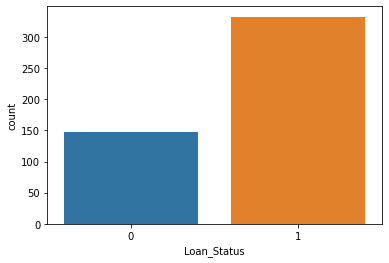

In [7]:
sns.countplot(y)
plt.show()

## Logistic Regression <a name="lr"></a>

In [8]:
# Pipeline to standardise at each fold
lr = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=SEED))])

In [9]:
lr_param_grid = {'model__penalty' : ['l1'],
                 'model__solver' : ['liblinear', 'saga'],
                 'model__C' : np.arange(0.1, 1.1, 0.1)}

lr_searcher = GridSearchCV(lr,
                           param_grid=lr_param_grid,
                           cv=10,
                           scoring='roc_auc',
                           return_train_score=True,
                           refit=True)
lr_searcher.fit(X_train_reg, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=1))]),
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__penalty': ['l1'],
                         'model__solver': ['liblinear', 'saga']},
             return_train_score=True, scoring='roc_auc')

### Result <a name="lr_result"></a>

In [10]:
lr_searcher.best_params_

{'model__C': 0.2, 'model__penalty': 'l1', 'model__solver': 'saga'}

In [11]:
best_lr = lr_searcher.best_estimator_
lr_coef_table = pd.concat([pd.DataFrame(X_train_reg.columns, columns=['Feature']),
                           pd.DataFrame(best_lr.named_steps['model'].coef_.round(4).reshape(-1), columns=['Coefficient'])],
                          axis=1)
lr_coef_table

,Feature,Coefficient
0,LoanAmount,-0.0579
1,ApplicantIncome,0.0000
2,CoapplicantIncome,-0.1586
3,Dependents_0,-0.1311
4,Dependents_1,0.0000
5,Dependents_2,0.0000
6,Dependents_3+,0.0378
7,Loan_Amount_Term_36,0.0000
8,Loan_Amount_Term_60,0.0000
9,Loan_Amount_Term_84,0.0000


### Evaluation <a name="lr_evaluation"></a>

In [12]:
X_train_reg_scaled = StandardScaler().fit_transform(X_train_reg)
lr_auc_train = roc_auc_score(y_train,
                             lr_searcher.predict_proba(X_train_reg_scaled)[:,1])
print("ROC-AUC of Logistic Regression (Train Set): " + str(lr_auc_train.round(4)))

ROC-AUC of Logistic Regression (Train Set): 0.8266


In [13]:
X_val_reg_scaled = StandardScaler().fit_transform(X_val_reg)
lr_auc_val = roc_auc_score(y_val,
                           best_lr.predict_proba(X_val_reg_scaled)[:,1])
print("ROC-AUC of Logistic Regression (Validation Set): " + str(lr_auc_val.round(4)))

ROC-AUC of Logistic Regression (Validation Set): 0.779


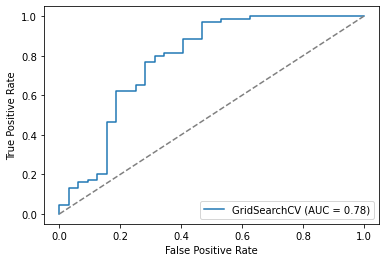

In [14]:
plot_roc_curve(lr_searcher, X_val_reg_scaled, y_val)
plt.plot([0, 1], [0, 1], '--', color="gray") # random guess
plt.show()

## Decision Tree <a name="dt"></a>

In [15]:
dt = DecisionTreeClassifier(random_state=SEED)

dt_param_grid = {'max_depth' : np.arange(1, 7, 1),
                 'min_samples_leaf' : np.arange(10, 50, 10)}

dt_searcher = GridSearchCV(dt,
                           param_grid=dt_param_grid,
                           cv=10,
                           scoring='roc_auc',
                           return_train_score=True,
                           refit=True)
dt_searcher.fit(X_train_tree, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6]),
                         'min_samples_leaf': array([10, 20, 30, 40])},
             return_train_score=True, scoring='roc_auc')

### Result <a name="dt_result"></a>

In [16]:
dt_searcher.best_params_

{'max_depth': 4, 'min_samples_leaf': 20}

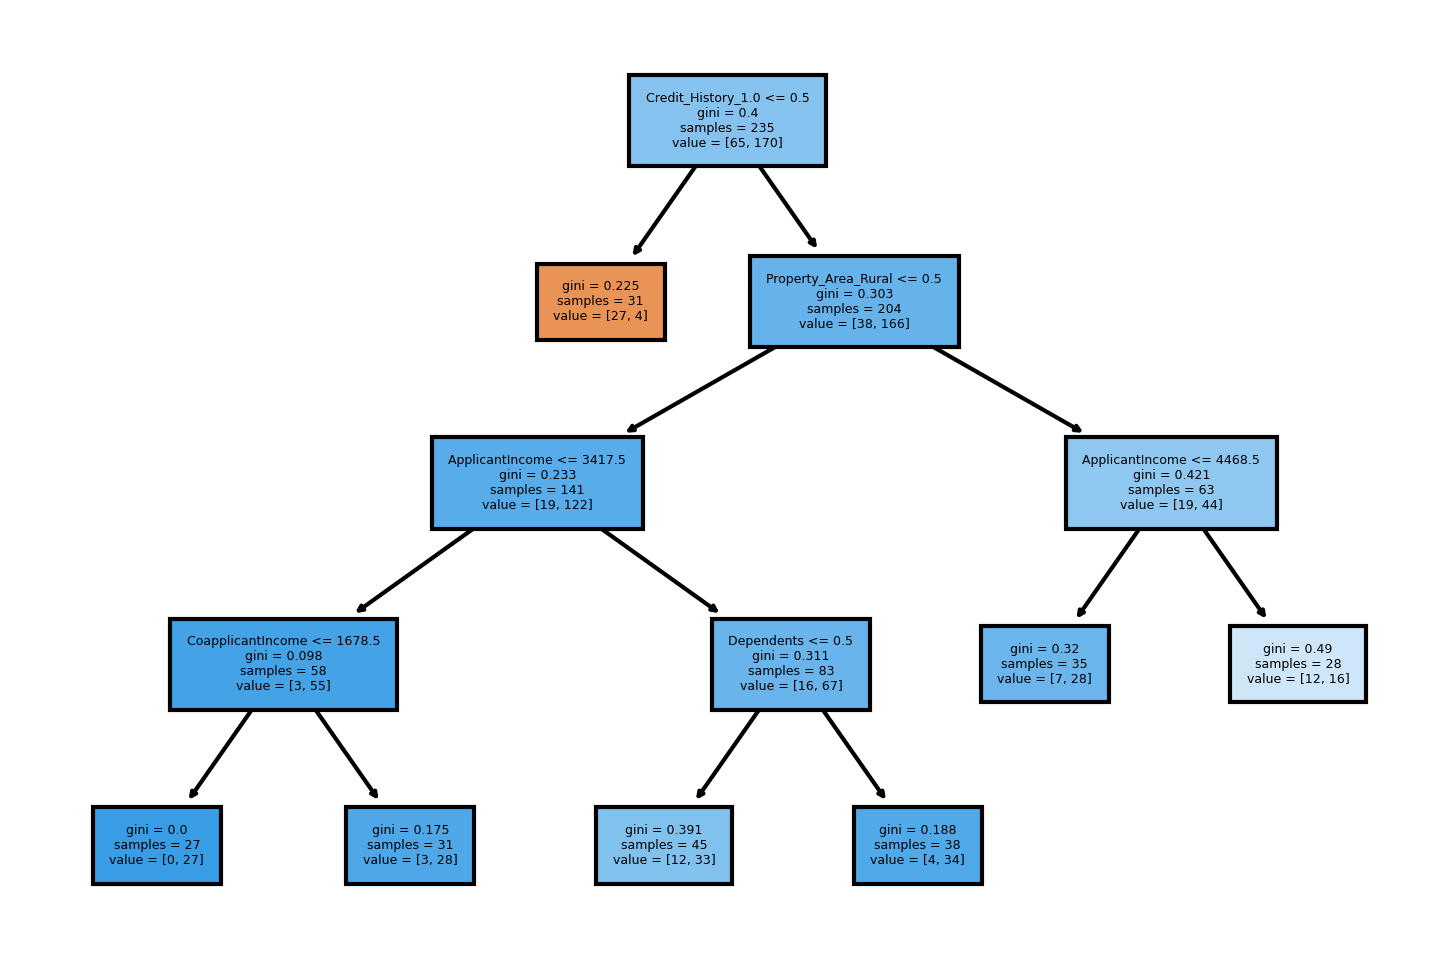

In [17]:
best_dt = dt_searcher.best_estimator_

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=300)
plot_tree(best_dt,
               feature_names=X_train_tree.columns,
               filled=True,
               fontsize=3)
#To save a image of the tree
#fig.savefig('dt.png')
plt.show()

### Evaluation <a name="dt_evaluation"></a>

In [18]:
dt_auc_train = roc_auc_score(y_train,
                             dt_searcher.predict_proba(X_train_tree)[:,1])
print("ROC-AUC of Decision Tree (Train Set): " + str(dt_auc_train.round(4)))

ROC-AUC of Decision Tree (Train Set): 0.8295


In [19]:
dt_auc_val = roc_auc_score(y_val,
                             dt_searcher.predict_proba(X_val_tree)[:,1])
print("ROC-AUC of Decision Tree (Validation Set): " + str(dt_auc_val.round(4)))

ROC-AUC of Decision Tree (Validation Set): 0.7414


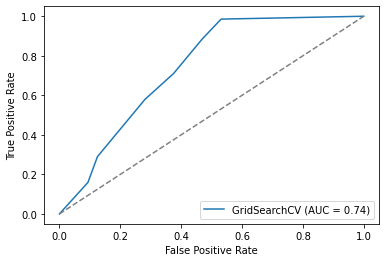

In [20]:
plot_roc_curve(dt_searcher, X_val_tree, y_val)
plt.plot([0, 1], [0, 1], '--', color="gray") # random guess
plt.show()

## K Nearest Neighbours <a name="knn"></a>

In [21]:
knn = Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())])

k_range = list(range(1, 31))
param_grid = {'model__n_neighbors': np.arange(1, 30)}
  
# defining parameter range
knn_searcher = GridSearchCV(estimator= knn, 
                            param_grid = param_grid, 
                            cv = 10, 
                            scoring='roc_auc', 
                            return_train_score=True, 
                            verbose=1,
                            refit=True)
  
# fitting the model for grid search
knn_searcher.fit(X_train_reg, y_train)

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    6.1s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             return_train_score=True, scoring='roc_auc', verbose=1)

### Result <a name="knn_result"></a>

In [22]:
knn_searcher.best_params_

{'model__n_neighbors': 29}

### Evaluation <a name="knn_evaluation"></a>

In [23]:
X_train_reg_scaled = StandardScaler().fit_transform(X_train_reg)
knn_auc_train = roc_auc_score(y_train,
                             knn_searcher.predict_proba(X_train_reg_scaled)[:,1])
print("ROC-AUC of K Nearest Neighbours (Train Set): " + str(knn_auc_train.round(4)))

ROC-AUC of K Nearest Neighbours (Train Set): 0.7857


In [24]:
X_val_reg_scaled = StandardScaler().fit_transform(X_val_reg)
knn_auc_val = roc_auc_score(y_val,
                             knn_searcher.predict_proba(X_val_reg_scaled)[:,1])
print("ROC-AUC of K Nearest Neighbours (Validation Set): " + str(knn_auc_val.round(4)))

ROC-AUC of K Nearest Neighbours (Validation Set): 0.7341


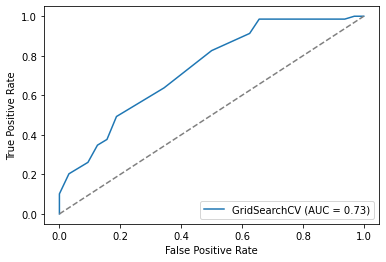

In [25]:
X_val_reg_scaled = StandardScaler().fit_transform(X_val_reg)
plot_roc_curve(knn_searcher, X_val_reg_scaled, y_val)
plt.plot([0, 1], [0, 1], '--', color="gray") # random guess
plt.show()

## Random Forest <a name="rf"></a>

In [26]:
rf = RandomForestClassifier(random_state=SEED)

rf_param_grid = {'n_estimators' : [15, 25, 50],
                 'max_depth' : np.arange(3, 7, 1),
                 'min_samples_leaf' : np.arange(5, 20, 5)}

rf_searcher = GridSearchCV(rf,
                           param_grid=rf_param_grid,
                           cv=10,
                           scoring='roc_auc',
                           return_train_score=True, 
                           refit=True)
rf_searcher.fit(X_train_tree, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': array([3, 4, 5, 6]),
                         'min_samples_leaf': array([ 5, 10, 15]),
                         'n_estimators': [15, 25, 50]},
             return_train_score=True, scoring='roc_auc')

### Result <a name="rf_result"></a>

In [27]:
rf_searcher.best_params_

{'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 15}

**Importance Plot:**

In [28]:
best_rf = rf_searcher.best_estimator_
rf_importance = pd.Series(best_rf.feature_importances_, index=X_train_tree.columns)
rf_sorted_importance = rf_importance.sort_values()

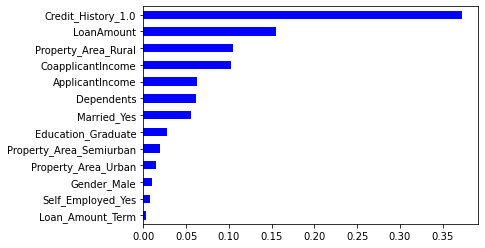

In [29]:
rf_sorted_importance.plot(kind='barh', color='blue')
plt.show()

### Evaluation <a name="rf_evaluation"></a>

In [30]:
rf_auc_train = roc_auc_score(y_train,
                             rf_searcher.predict_proba(X_train_tree)[:,1])
print("ROC-AUC of Random Forest (Train Set): " + str(rf_auc_train.round(4)))

ROC-AUC of Random Forest (Train Set): 0.8822


In [31]:
rf_auc_val = roc_auc_score(y_val,
                             rf_searcher.predict_proba(X_val_tree)[:,1])
print("ROC-AUC of Random Forest (Validation Set): " + str(rf_auc_val.round(4)))

ROC-AUC of Random Forest (Validation Set): 0.8003


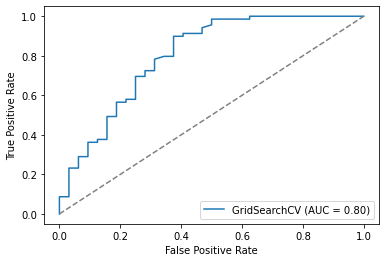

In [32]:
plot_roc_curve(rf_searcher, X_val_tree, y_val)
plt.plot([0, 1], [0, 1], '--', color="gray") # random guess
plt.show()

## Gradient Boost <a name="gb"></a>

In [33]:
gb = GradientBoostingClassifier(random_state=SEED)

gb_param_grid = {'n_estimators' : [150, 200, 250],
                 'max_depth' : np.arange(1, 5, 1),
                 'min_samples_leaf' : [20, 30, 40]}

gb_searcher = GridSearchCV(gb,
                           param_grid=gb_param_grid,
                           cv=10,
                           scoring='roc_auc',
                           return_train_score=True, 
                           refit=True)
gb_searcher.fit(X_train_tree, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'max_depth': array([1, 2, 3, 4]),
                         'min_samples_leaf': [20, 30, 40],
                         'n_estimators': [150, 200, 250]},
             return_train_score=True, scoring='roc_auc')

### Result <a name="gb_result"></a>

In [34]:
gb_searcher.best_params_

{'max_depth': 1, 'min_samples_leaf': 20, 'n_estimators': 150}

In [35]:
best_gb = gb_searcher.best_estimator_
gb_importance = pd.Series(best_gb.feature_importances_, index=X_train_tree.columns)
gb_sorted_importance = gb_importance.sort_values()

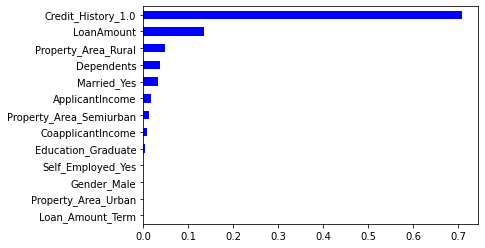

In [36]:
gb_sorted_importance.plot(kind='barh', color='blue')
plt.show()

### Evaluation <a name="gb_evaluation"></a>

In [37]:
gb_auc_train = roc_auc_score(y_train,
                             gb_searcher.predict_proba(X_train_tree)[:,1])
print("ROC-AUC of Gradient Boost (Train Set): " + str(gb_auc_train.round(4)))

ROC-AUC of Gradient Boost (Train Set): 0.8584


In [38]:
gb_auc_val = roc_auc_score(y_val,
                             gb_searcher.predict_proba(X_val_tree)[:,1])
print("ROC-AUC of Gradient Boost (Validation Set): " + str(gb_auc_val.round(4)))

ROC-AUC of Gradient Boost (Validation Set): 0.7817


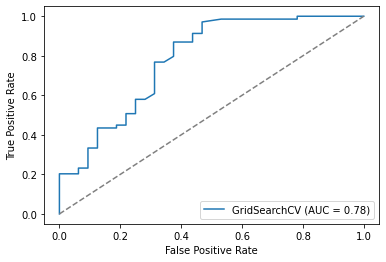

In [39]:
plot_roc_curve(gb_searcher, X_val_tree, y_val)
plt.plot([0, 1], [0, 1], '--', color="gray") # random guess
plt.show()

## Comparing Models <a name="comparing_models"></a>

In [40]:
pd.DataFrame({"Model": ["Logistic Regression", "Decision Tree", "K Nearest Neighbours", 
                        "Random Forest", "Gradient Boost"],
              "Training ROC-AUC Score": [lr_auc_train, dt_auc_train, knn_auc_train, 
                                         rf_auc_train, gb_auc_train],
              "Validation ROC-AUC Score": [lr_auc_val, dt_auc_val, knn_auc_val,
                                          rf_auc_val, gb_auc_val]})

,Model,Training ROC-AUC Score,Validation ROC-AUC Score
0,Logistic Regression,0.826606,0.778986
1,Decision Tree,0.829502,0.741395
2,K Nearest Neighbours,0.785656,0.734149
3,Random Forest,0.882217,0.800272
4,Gradient Boost,0.858371,0.781703


## Final Model: Logistic Regression <a name="final_model"></a>

### Test Result <a name="test_result"></a>

In [41]:
X_test_reg_scaled = StandardScaler().fit_transform(X_test_reg)

lr_auc_test = roc_auc_score(y_test,
                             lr_searcher.predict_proba(X_test_reg_scaled)[:,1])
print("ROC-AUC of Logistic Regression (Test Set): " + str(lr_auc_test.round(4)))

ROC-AUC of Logistic Regression (Test Set): 0.7065


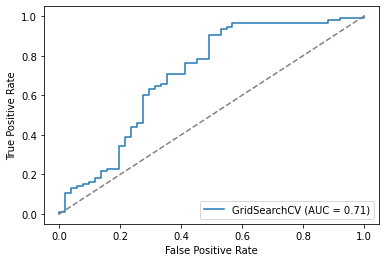

In [42]:
plot_roc_curve(lr_searcher, X_test_reg_scaled, y_test)
plt.plot([0, 1], [0, 1], '--', color="gray") # random guess
plt.show()

### Benefit Analysis <a name="benefit"></a>

In [43]:
def getCM(thresholds, model, X_train, y_train):
    cm = []
    for i in range(len(thresholds)):
        p = model.predict_proba(X_train)[:,1]
        threshold = thresholds[i]
        y_pred = np.where(p > threshold, 1, 0)
        cm.append(confusion_matrix(y_train, y_pred))
    
    return cm

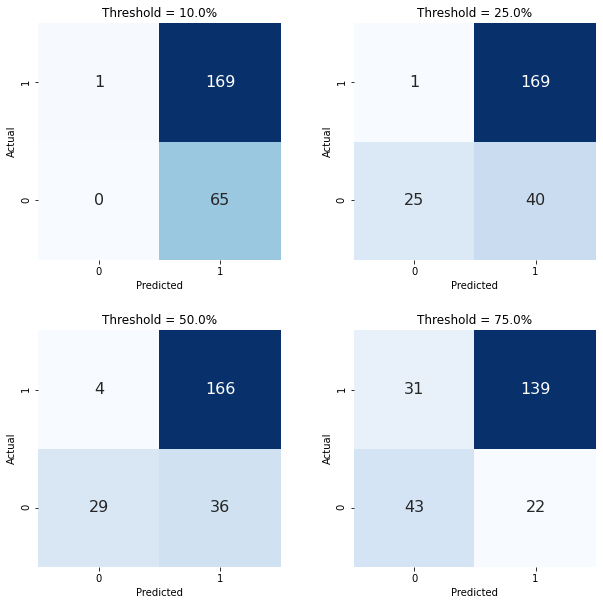

In [44]:
thresholds = [0.1, 0.25, 0.5, 0.75]

cm = getCM(thresholds, lr_searcher, X_train_reg, y_train)

fig, axes = plt.subplots(figsize=(10,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(len(thresholds)):
    ax = plt.subplot(math.ceil(len(thresholds)/2), 2, i+1)
    sns.heatmap(cm[i], annot=True, fmt='d', cbar=False, cmap='Blues', annot_kws={"fontsize":16})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual'); 
    ax.set_title('Threshold = ' + str(thresholds[i]*100) + '%');
    ax.set_ylim([0,2])


plt.show()

In [45]:
def calcBenefit(cm, benefits):
    calc = []
    
    for i in range(len(cm)):
        tn, fp, fn, tp = cm[i].ravel()
        calc.append(tp*benefits["tp"] + fn*benefits["fn"] + fp*benefits["fp"] + 
                    tn*benefits["tn"] + (tp+fp)*benefits["action"])
    
    return calc        

In [46]:
benefit_struct_1 = {"tp": 100, "fn": -150, "fp": -50, "tn": 0, "action": -10}
benefit_1 = pd.DataFrame({"Threshold": thresholds, "Benefit": calcBenefit(cm, benefit_struct_1)})
benefit_1

,Threshold,Benefit
0,0.10,11160
1,0.25,12660
2,0.50,12180
3,0.75,6540


In [47]:
benefit_struct_2 = {"tp": 100, "fn": -50, "fp": -150, "tn": 0, "action": -10}
benefit_2 = pd.DataFrame({"Threshold": thresholds, "Benefit": calcBenefit(cm, benefit_struct_2)})
benefit_2

,Threshold,Benefit
0,0.10,4760
1,0.25,8760
2,0.50,8980
3,0.75,7440
